In [69]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

import collections
import hashlib
import numbers

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear

here  I try to use the native RNN cell type in Tensorflow to implement a spiking network layer. An RNN is defined as any cell that has input, states, and a call function that takes the input and state, and produce next_state, and output;
https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/RNNCell

in the implementation, we assume spikes from m input cells are arrived, and train both $W_{in}$ and $W_{rec}$
state of the network are the three following variables $v_{membrane},\ t_{reset},\ g(t)$

In [292]:
_INPUT_WEIGHT_NAME = "W_in"
_RECURRENT_WEIGHT_NAME = "W_rec"
## crossing function
def _calcualte_crossings(x,threshold):
    """input :x : a 2D tensor with batch x n 
    outputs a tensor with the same size as x 
    and values of 0 or 1 depending on comparison between 
    x and threshold""" 
    @tf.custom_gradient
    def crossings(x):
        dtype=x.dtype
        shape=x.get_shape()
        thresholds=tf.constant(threshold,shape=[shape[0].value,shape[1].value],dtype=dtype)
        # if it has one row 
        res=tf.greater_equal(x,thresholds)
        def grad(dy):
            # calculate 1-|x|
            temp=1-tf.abs(x)
            dyres=tf.maximum(temp,0.0)
            return dyres
        return tf.cast(res,dtype=dtype), grad
    z=crossings(x)
    return z 

## conductance update function 
def _tensor_linear_rec_in(x,y,output_size):
    """input - x : a 3D tensor with batch x n x n 
    y is a 3D with size batch x n x m
    outputs a tensor  with size batch x output_size,
    """ 
    shape_x=x.get_shape()
    shape_y=y.get_shape()
    # 
    scope=vs.get_variable_scope()
    with vs.variable_scope(scope) as outer_scope:
        weight_rec=tf.get_variable(_RECURRENT_WEIGHT_NAME,[shape_x[1],shape_x[2]]) # [n x n]
        weight_in=tf.get_variable(_INPUT_WEIGHT_NAME,[shape_y[1],shape_y[2]]) # [n x m]
        #w_in_test= lambda:tf.constant(0.0,shape=[shape_y[1],shape_y[2]]) # [n x n]
        #w_rec_test= lambda:tf.constant(0.0,shape=[shape_x[1],shape_x[2]]) # [n x n]
        #weight_rec=tf.Variable(initial_value=w_rec_test,dtype=tf.float32) # [n x n]
        #weight_in=tf.Variable(initial_value=w_in_test,dtype=tf.float32) # [n x n]
        # apply_weights 
        #recurrent
        res_rec_aux=tf.multiply(x,weight_rec)
        res_rec_final=tf.reduce_sum(res_rec_aux,tf.rank(res_rec_aux)-1)
        #input
        res_in_aux=tf.multiply(y,weight_in)
        res_in_final=tf.reduce_sum(res_in_aux,tf.rank(res_in_aux)-1)
        # sum both 
        res=tf.add(res_in_final,res_rec_final)
        return res

## expand dimensions for incoming spikes 
def _tensor_expand_dim(x,y,output_size):
    """input - x : a 2D tensor with batch x n 
    y is a 2D with size batch x m
    outputs is 3D tensor with size batch x n x n and batch x n x m 
    """ 
    shape_x=x.get_shape()
    shape_y=y.get_shape()
    #y=tf.cast(y,tf.float32)
    # define a matrix for removing the diagonal in recurrent spikes 
    diag_zero= lambda:tf.subtract(tf.constant(1.0,shape=[shape_x[1],shape_x[1]]),
                                                    tf.eye(output_size))
    x_diag_fixer = tf.Variable(initial_value=diag_zero, dtype=tf.float32)
    # expand x  
    x_temp=tf.reshape(tf.tile(x,[1,output_size]),[-1,output_size,shape_x[1]])
    # remove diagonal 
    x_expand=tf.multiply(x_temp,x_diag_fixer)
    # expand y  
    y_expand=tf.reshape(tf.tile(y,[1,output_size]),[-1,output_size,shape_y[1]])
    return x_expand, y_expand



## define tuples for the cell 
_SNNStateTuple = collections.namedtuple("SNNStateTuple", ("v_mem","spike","t_reset", "S_rec","S_in"))
_SNNOutputTuple = collections.namedtuple("SNNOutputTuple", ("v_mem","spike","g_mem","t_reset", "S_rec","S_in"))

class SNNStateTuple(_SNNStateTuple):
  """Tuple used by SNN Cells for `state_variables `, and output state.
  Stores five elements: `(v_mem,spike, t_reset, S_rec, S_in)`, in that order. Where `v_mem` is the hidden state
  , spike is output, `S_rec` and 'S_in' are spike history, and t_reset refractory history.
  Only used when `state_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (v_mem, spike,t_reset, S_rec, S_in ) = self
    if v_mem.dtype != spike.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(v_mem.dtype), str(spike.dtype)))
    return spike.dtype


class SNNOutputTuple(_SNNOutputTuple):
  """Tuple used by SNN Cells for output state.
  Stores six elements: `(v_mem,spike ,G_mem ,t_reset, S_rec, S_in)`, 
  Only used when `output_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (v_mem,spike,g_mem ,t_reset, S_rec, S_in) = self
    if v_mem.dtype != spike.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(v_mem.dtype), str(spike.dtype)))
    return spike.dtype


## define SNNcell 
class SNNCell(tf.contrib.rnn.RNNCell):
  """Spiking Neural Network Cell
  Args:
    num_units: int, The number of units in the GRU cell.
    activation: Nonlinearity to use.  Default: `tanh`.
    reuse: (optional) Python boolean describing whether to reuse variables
     in an existing scope.  If not `True`, and the existing scope already has
     the given variables, an error is raised.
    kernel_initializer: (optional) The initializer to use for the weight and
    projection matrices.
    bias_initializer: (optional) The initializer to use for the bias.
  """
  def __init__(self,
               num_units,
               num_inputs,
               tau_m=5.0,
               v_theta=1.0,
               v_reset=0.0,
               tau_s=5.0,
               tau_refract=3.0,
               dt=1.0,
               activation=None,
               reuse=None,
               kernel_initializer=None,
               bias_initializer=None,
               state_is_tuple=False,
               output_is_tuple=False):
        
    super(SNNCell, self).__init__(_reuse=reuse)
    self._num_units = num_units
    self._num_inputs = num_inputs
    self.tau_m=tau_m
    self.v_theta=v_theta
    self.v_reset=v_reset
    self.tau_s=tau_s
    self.tau_refract=tau_refract
    self.dt=dt
    self._activation = activation or math_ops.tanh
    self._kernel_initializer = kernel_initializer
    self._bias_initializer = bias_initializer
    self._state_is_tuple= state_is_tuple
    self._output_is_tuple= output_is_tuple
    self._calculate_crossing= _calcualte_crossings
    self._tensor_expand_dim = _tensor_expand_dim
    self._tensor_linear_rec_in = _tensor_linear_rec_in


  @property
  def state_size(self):
    return (SNNStateTuple(self._num_units,
                          self._num_units,
                          self._num_units,
                          np.array([self._num_units,self._num_units]),
                          np.array([self._num_units,self._num_inputs])) if self._state_is_tuple else self._num_units)
                          

#  @property
#  def output_size(self):
#    return self._num_units
  @property
  def output_size(self):
    return (SNNOutputTuple(self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units,
                          np.array([self._num_units,self._num_units]),
                          np.array([self._num_units,self._num_inputs])) if self._state_is_tuple else self._num_units)
    

  def call(self, inputs, state):
    """Spiking Neuron Cell (SNN).
    Args:
      inputs: `2-D` tensor with shape `[batch_size x input_size]`.
      state: An `SNNStateTuple` of state tensors, shaped as following 
              `[batch_size x self.state_size]`
              `[batch_size x self.state_size]`
              `[batch_size x self.state_size]`
              `[batch_size x self.state_size x self.state_size]`
              `[batch_size x self.state_size x self.state_size]`
        `[batch_size x self.state_size]`.
    Returns:
      A pair containing the new output, and the new state as SNNStateTuple
    """
    if self._state_is_tuple:
        v_mem,spike, t_reset, S_rec, S_in = state
    else: 
        logging.warn("%s: Please use float ", self)
    # initialize crossing function 
    #if self._calculate_crossing is None:
    #    self._calculate_crossing = _calcualte_crossings(v_mem,self.v_theta)
        
    #if self._tensor_expand_dim is None:
    #    self._tensor_expand_dim = _tensor_expand_dim(spike,inputs,self._num_units)
    
    
    # compoutation 
    # 1-get spikes 
    spike=self._calculate_crossing(v_mem,self.v_theta)
    #v_reseting=tf.scalar_mul(self.v_theta,spike)
    v_reseting=tf.multiply(v_mem,spike)
    v_update=tf.subtract(v_mem,v_reseting)
    ## get conductance 
        # expand input spikes and recurent spikes 
    spike_expand,inputs_expand=self._tensor_expand_dim(spike,inputs,self._num_units)
    
        # decay previous values and threshold them 
        # recurrent 
    #if True:
    #    logging.warn("%s: Please use state tuple ", tf.shape(S_in))  
        
    S_rec_subtract=S_rec-tf.divide(S_rec,self.tau_s)
        # remove values below zero 
    S_rec_update=tf.clip_by_value(S_rec_subtract,0.0,200)
        # input 
    S_in_subtract=S_in-tf.divide(S_in,self.tau_s)
        # remove values below zero 
    S_in_update=tf.clip_by_value(S_in_subtract,0.0,200)
    
    # update S_rec and S_in
    S_rec_new=tf.add(S_rec_update,spike_expand)
    S_in_new=tf.add(S_in_update,inputs_expand)
    
    # calculate new G = W*S 
    G_neuron=self._tensor_linear_rec_in(S_rec_new,S_in_new,self._num_units)
    
    ## compute I_input 
    I_input=tf.multiply(G_neuron,v_mem)+.1
    
    ## update membrane potential 
        # update refractory period 
    t_subtract= tf.subtract(t_reset,1.0)
    t_update=tf.clip_by_value(t_subtract,0.0,100)
    t_reset_new=tf.add(tf.multiply(spike,self.tau_refract),t_update)
        # get eligible neurons for update 
    eligilible_update=tf.cast(tf.equal(t_reset_new,0.0),tf.float32)
        # update voltage
    dV_op=tf.multiply(eligilible_update,tf.divide(tf.subtract(I_input,v_update),self.tau_m))
    v_mem_new=tf.add(v_update,tf.multiply(dV_op,self.dt))
    
    ## return variables 
    
    if self._state_is_tuple:
        new_state = SNNStateTuple( v_mem_new, spike,t_reset_new, S_rec_new, S_in_new )
    if self._output_is_tuple:
        new_output = SNNOutputTuple(v_mem_new, spike,G_neuron ,t_reset_new, S_rec_new, S_in_new )
    else:
        new_output = spike
    return new_output, new_state


example implementation 1 neuron 

rnn/while/rnn/snn_cell/Variable:0 [[0.]]
rnn/snn_cell/W_rec:0 [[0.784356]]
rnn/snn_cell/W_in:0 [[-0.52475977]]


Text(0.5, 1.0, 'Spike')

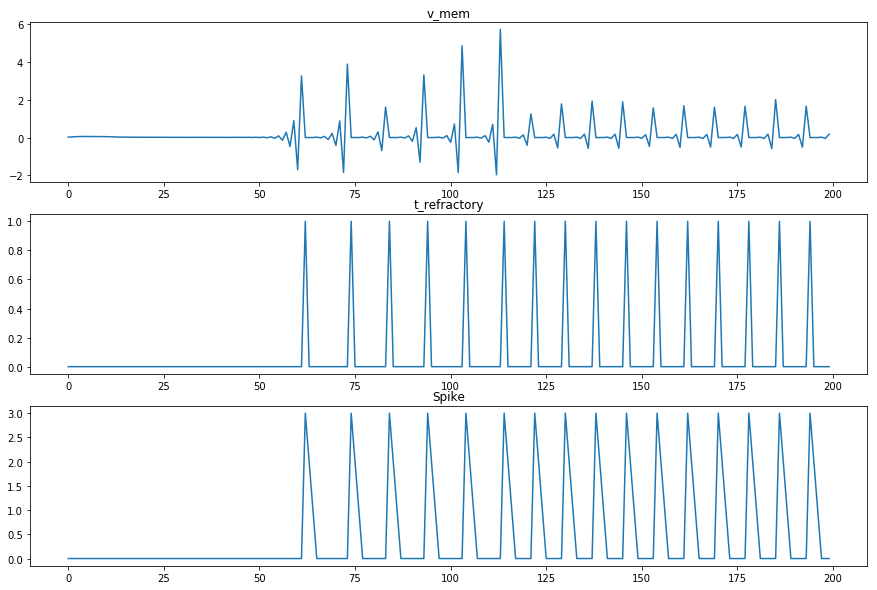

In [293]:
batch_size = 1
sequence_length = 200
num_inputs = 1
num_units=1
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
SNN_cell = SNNCell(num_units=num_units,state_is_tuple=True,output_is_tuple=True,num_inputs=num_inputs,tau_s=100.0)
outputs, state = tf.nn.dynamic_rnn(cell=SNN_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,10])
ax=plt.subplot(3,1,1)
ax.plot(output_run.v_mem.flatten())
ax.set_title('v_mem')
ax=plt.subplot(3,1,2)
ax.plot(output_run.spike.flatten())
ax.set_title('t_refractory')
ax=plt.subplot(3,1,3)
ax.plot(output_run.t_reset.flatten())
ax.set_title('Spike')

example implementation 3 neurons, 2 inputs 

rnn/while/rnn/snn_cell/Variable:0 [[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]
rnn/snn_cell/W_rec:0 [[ 0.8285878  -0.43288422 -0.8383498 ]
 [ 0.8498206   0.08978939  0.8774402 ]
 [-0.7624576   0.22128963  0.54825354]]
rnn/snn_cell/W_in:0 [[ 1.0872755  -0.49951762]
 [-0.25057918  0.28236377]
 [-0.1666497  -1.0835351 ]]


Text(0.5, 1.0, 'Spike')

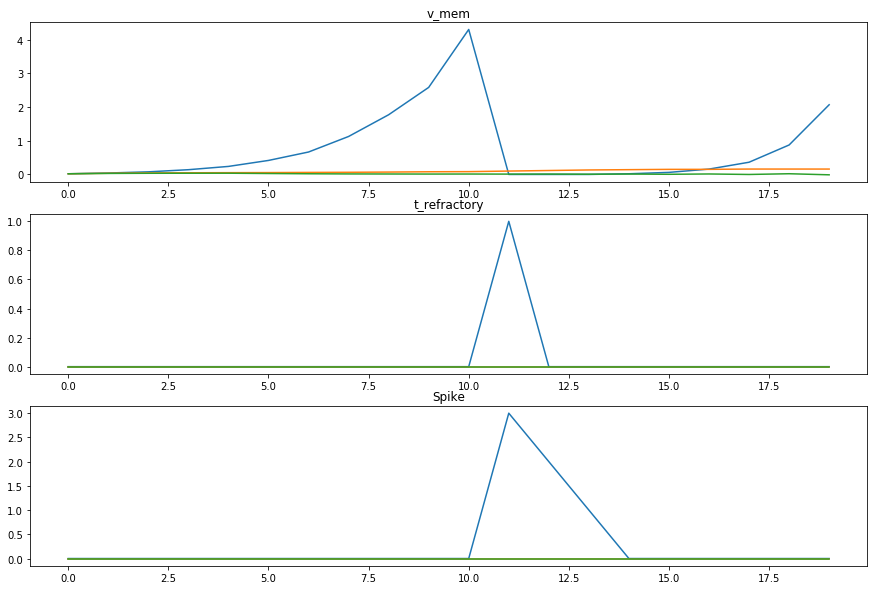

In [289]:
batch_size = 1
sequence_length = 20
num_inputs = 2
num_units=3
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
SNN_cell = SNNCell(num_units=num_units,state_is_tuple=True,output_is_tuple=True,num_inputs=num_inputs,tau_s=100.0)
outputs, state = tf.nn.dynamic_rnn(cell=SNN_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,10])
ax=plt.subplot(3,1,1)
ax.plot(output_run.v_mem.squeeze(axis=0))
ax.set_title('v_mem')
ax=plt.subplot(3,1,2)
ax.plot(output_run.spike.squeeze(axis=0))
ax.set_title('t_refractory')
ax=plt.subplot(3,1,3)
ax.plot(output_run.t_reset.squeeze(axis=0))
ax.set_title('Spike')

In [291]:
output_run.spike.squeeze(axis=0)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)